# OUTDATED

In [96]:
import xarray as xr
import numpy as np

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt

In [37]:
path = r"..\data\raw\RSS_SMAP_WINSAT_DAILY_TBTOA_MAPS_2017_01_01.nc"
ds = xr.open_dataset(path, engine="h5netcdf", decode_times=False)
ds

<xarray.Dataset> Size: 2GB
Dimensions:         (longitude_grid: 1440, latitude_grid: 720, swath_sector: 2,
                     look_direction: 2, frequency_band: 6, polarization: 4,
                     polarization_dual: 2)
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                look_direction, frequency_band, polarization,
                                polarization_dual
Data variables: (12/43)
    longitude       (longitude_grid) float32 6kB ...
    latitude        (latitude_grid) float32 3kB ...
    node            (swath_sector) int32 8B ...
    look            (look_direction) int32 8B ...
    frequency_vpol  (frequency_band) float32 24B ...
    frequency_hpol  (frequency_band) float32 24B ...
    ...              ...
    colcld_WSAT     (latitude_grid, longitude_grid, swath_sector) float32 8MB ...
    rain_IMERG      (latitude_grid, longitude_grid, swath_sector) float32 8MB ...
    rain_WSAT       (latitude_grid, longitude_grid, swath_sector) float32 8MB ...
    tran            (polarization_dual, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 199MB ...
    tbup            (polarization_dual, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 199MB ...
    tbdw            (polarization_dual, frequency_band, latitude_grid, longitude_grid, look_direction, swath_sector) float32 199MB ...
Attributes: (12/75)
    Conventions:                            CF-1.7
    title:                                  RSS SMAP-WindSat TOA Brightness T...
    version:                                V01.0
    summary:                                The dataset contains matchups of ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_ARGO_SSS:           Holte, J., L. D. Talley, J. Gilso...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    id:                                     https://doi.org/10.56236/RSS-bj
    naming_authority:                       https://www.crossref.org/

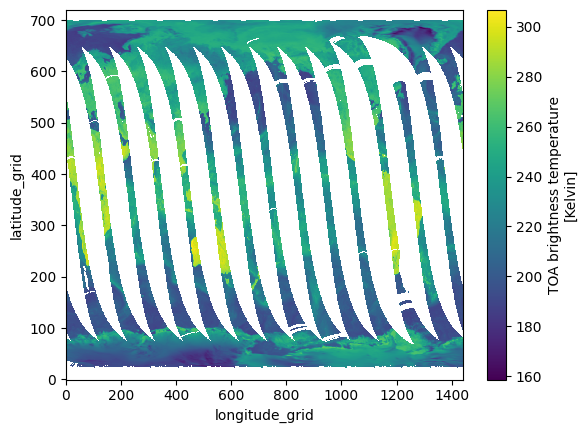

In [5]:
ds.tbtoa.sel(frequency_band=4, look_direction=0, swath_sector=0, polarization=0).plot()

In [ ]:
""" 
THe files are massive and we only need tbToA for 37 and 18 GHz, look = forward and also to splitt them into ascending and descending swath

- Download the files

- Select the desired variables

selec for the frequency bands that we need in the TbToA variable

Correct for the latitude and longitude grid to be in degrees. (?)

Shift the longitude (0,360) -> (-180, 180)

mask the oceans 

save the processed day

Other data we could need: 

 - quality flags
 --- 

 Later we could combine all datafiles into a single cube, depending on the size
"""

In [42]:
# Select Variables
variables = ["tbtoa", "quality_flag", "latitude", "longitude"]
selected_ds = ds[variables]

# Select dimensions
selected_ds = selected_ds.sel(
    indexers={
        "polarization": [0, 1],  # [ V, H ]
        "frequency_band": [2, 4],  # [ 18.7 GHz (Ku) , 37.0 GHz (Ka) ]
        "look_direction": 0,  # Forward
    }
)
# Roll lattitude grid so we have -180, 180 range
selected_ds = selected_ds.roll(shifts={"longitude_grid": 4 * 180})

# Extract latitude and longitude grid dimensions
lat_dim = selected_ds.sizes["latitude_grid"]
lon_dim = selected_ds.sizes["longitude_grid"]

# Definition of the grid used
lat_resolution = 0.25
lon_resolution = 0.25
start_lat = -90.0
start_lon = -180.0

# Create latitude and longitude coordinate arrays
lat = xr.DataArray(
    start_lat + lat_resolution * (np.arange(lat_dim)), dims=("latitude_grid",)
)
lon = xr.DataArray(
    start_lon + lon_resolution * (np.arange(lon_dim)), dims=("longitude_grid",)
)

# Update dataset with latitude and longitude coordinates
selected_ds = selected_ds.assign_coords(lat=lat, lon=lon)
selected_ds

<xarray.Dataset> Size: 41MB
Dimensions:       (polarization: 2, frequency_band: 2, latitude_grid: 720,
                   longitude_grid: 1440, swath_sector: 2)
Coordinates:
    lat           (latitude_grid) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75
    lon           (longitude_grid) float64 12kB -180.0 -179.8 ... 179.5 179.8
Dimensions without coordinates: polarization, frequency_band, latitude_grid,
                                longitude_grid, swath_sector
Data variables:
    tbtoa         (polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 33MB ...
    quality_flag  (latitude_grid, longitude_grid, swath_sector) int32 8MB 5 ....
    latitude      (latitude_grid) float32 3kB ...
    longitude     (longitude_grid) float32 6kB 180.1 180.4 180.6 ... 179.6 179.9
Attributes: (12/75)
    Conventions:                            CF-1.7
    title:                                  RSS SMAP-WindSat TOA Brightness T...
    version:                                V01.0
    summary:                                The dataset contains matchups of ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_ARGO_SSS:           Holte, J., L. D. Talley, J. Gilso...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    id:                                     https://doi.org/10.56236/RSS-bj
    naming_authority:                       https://www.crossref.org/

C:\Users\andre\AppData\Local\Temp\ipykernel_11392\2347449390.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  selected_ds.dims["latitude_grid"]


720

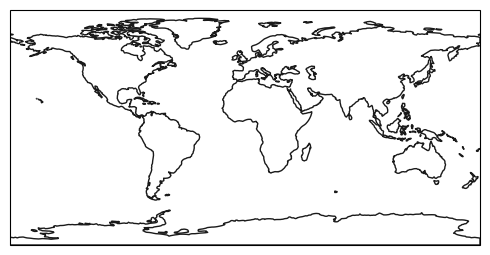

In [14]:
import regionmask
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

land = regionmask.defined_regions.natural_earth_v5_0_0.land_110

fig, ax = plt.subplots(
    1, 1, figsize=(5, 5), subplot_kw={"projection": ccrs.PlateCarree()}
)

ax.add_geometries(land.polygons, ccrs.PlateCarree(), fc="none", ec="0.1")

fig.tight_layout()

In [44]:
lon = selected_ds["longitude"]
lat = selected_ds["latitude"]

ocean_mask = regionmask.defined_regions.natural_earth_v5_1_2.ocean_basins_50.mask(
    lon, lat
)
masked_ds = selected_ds.where(ocean_mask == 0)

masked_ds.sel(swath_sector=0, frequency_band=0, polarization=1).tbtoa.plot()

ValueError: operands could not be broadcast together with shapes (1440,) (1036800,) 

In [9]:
mask = ocean_mask.mask

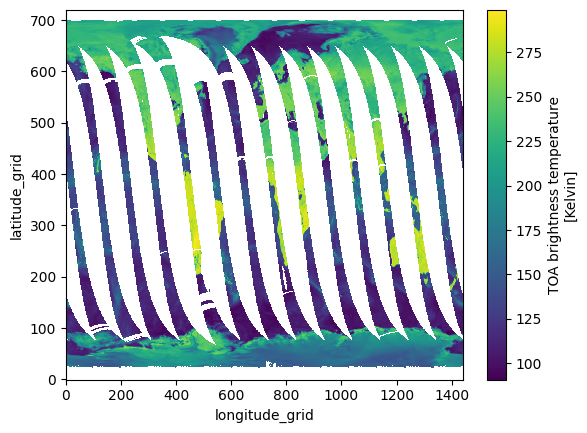

In [49]:
# Test: Ka band H descending
selected_ds.sel(swath_sector=0, frequency_band=0, polarization=1).tbtoa.plot()

In [50]:
# Save this into a new file to test memory sizes:
newpath = r"../data/processed/RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_01.nc"
selected_ds.to_netcdf(newpath)

In [53]:
# Test reloading:
ds = xr.open_dataset(newpath)
ds

<xarray.Dataset> Size: 41MB
Dimensions:       (polarization: 2, frequency_band: 2, latitude_grid: 720,
                   longitude_grid: 1440, swath_sector: 2)
Dimensions without coordinates: polarization, frequency_band, latitude_grid,
                                longitude_grid, swath_sector
Data variables:
    tbtoa         (polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 33MB ...
    quality_flag  (latitude_grid, longitude_grid, swath_sector) int32 8MB ...
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [76]:
# # Dowload the data from the site
""" SINGLE DOWNLOAD FROM LINK """
# import requests
# import os

# base_url = "https://images.remss.com/~RSS-TB/intercalibration/windsat_TB_maps_daily_025deg/RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_"  # _01_01.nc
# end_url = ".nc"

# start_date = datetime(2017, 1, 1)
# end_date = datetime(2017, 1, 1)

# current_date = start_date
# while current_date <= end_date:

#     month = str(current_date.month).zfill(2)
#     day = str(current_date.day).zfill(2)
#     url = f"{base_url}{month}_{day}{end_url}"

#     save_dir = r"../data/raw/daily_Windsat/"
#     save_file = url.split("/")[-1]
#     save_path = os.path.join(save_dir, save_file)

#     # Check if the file exists:
#     if not os.path.exists(save_path):
#         print("Downloading data from \n", url)
#         try:
#             with requests.get(url, stream=True) as r:
#                 r.raise_for_status()
#                 with open(save_path, "wb") as f:
#                     for chunk in r.iter_content(chunk_size=8192):
#                         f.write(chunk)

#         except requests.exceptions.RequestException as e:
#             print(f"Error downloading {save_file}: {e}")

#     current_date += timedelta(days=1)

https://images.remss.com/~RSS-TB/intercalibration/windsat_TB_maps_daily_025deg/RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_01.nc


In [1]:
# Async implementation of the download
""" DEPRECATED"""
# from concurrent.futures import ThreadPoolExecutor
# from datetime import datetime, timedelta
# import requests
# import os


# def download_file(url, save_path):
#     try:
#         print("Started download: {save_path}")
#         with requests.get(url, stream=True) as r:
#             r.raise_for_status()
#             with open(save_path, "wb") as f:
#                 for chunk in r.iter_content(chunk_size=8192):
#                     f.write(chunk)

#         print(f"Downloaded {save_path}")

#     except requests.exceptions.RequestException as e:
#         print(f"Error downloading {save_path}: {e}")


# def concurrent_download(dates):
#     with ThreadPoolExecutor(max_workers=4) as executor:
#         futures = []
#         for date in dates:
#             base_url = "https://images.remss.com/~RSS-TB/intercalibration/windsat_TB_maps_daily_025deg/RSS_WINDSAT_DAILY_TBTOA_MAPS"
#             year = str(date.year).zfill(4)
#             month = str(date.month).zfill(2)
#             day = str(date.day).zfill(2)
#             end_url = ".nc"

#             url = f"{base_url}_{year}_{month}_{day}{end_url}"

#             save_dir = "../data/raw/daily_Windsat/"
#             save_file = url.split("/")[-1]
#             save_path = os.path.join(save_dir, save_file)

#             # Check if file already exists
#             if not os.path.exists(save_path):
#                 print(f"Queuing download for {save_file}")
#                 futures.append(executor.submit(download_file, url, save_path))

#         for future in futures:
#             future.result()


# # Generate date range
# start_date = datetime(2017, 1, 1)
# end_date = datetime(2017, 2, 1)
# dates = [
#     start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)
# ]

# concurrent_download(dates)
# print("DONE")

Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_01.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_09.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_11.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_12.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_13.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_14.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_15.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_16.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_17.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_18.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_19.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_20.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_21.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_22.nc
Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_23.nc
Queuing download for RSS_WINDSAT_DAILY_T

In [79]:
import aiohttp
import asyncio
import os
from datetime import datetime, timedelta


async def download_file(url, save_path):
    try:
        async with aiohttp.ClientSession(
            timeout=aiohttp.ClientTimeout(total=None)
        ) as session:
            async with session.get(url) as response:
                with open(save_path, "wb") as f:
                    while True:
                        chunk = await response.content.read(8192)
                        if not chunk:
                            print(f"Downloaded {save_path}")
                            break
                        f.write(chunk)
    except aiohttp.ClientError as e:
        print(f"Error downloading {url}: {e}")


async def concurrent_download(dates):
    tasks = []
    base_url = "https://images.remss.com/~RSS-TB/intercalibration/windsat_TB_maps_daily_025deg/RSS_WINDSAT_DAILY_TBTOA_MAPS"
    save_dir = "../data/raw/daily_Windsat/"

    for date in dates:
        year = str(date.year).zfill(4)
        month = str(date.month).zfill(2)
        day = str(date.day).zfill(2)
        end_url = ".nc"

        url = f"{base_url}_{year}_{month}_{day}{end_url}"
        save_file = url.split("/")[-1]
        save_path = os.path.join(save_dir, save_file)

        if not os.path.exists(save_path):
            print(f"Queuing download for {save_file}")
            tasks.append(download_file(url, save_path))

    await asyncio.gather(*tasks)


start_date = datetime(2017, 1, 1)
end_date = datetime(2017, 2, 1)
dates = [
    start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)
]

await concurrent_download(dates)
print("DONE")

Queuing download for RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_18.nc
Downloaded ../data/raw/daily_Windsat/RSS_WINDSAT_DAILY_TBTOA_MAPS_2017_01_18.nc
DONE


In [95]:
# # Code to process all the files in a month and make a datacube (Xarray) of the TBToA
# import re
# from tqdm import tqdm

# def process_dataset(ds: xr.Dataset) -> xr.Dataset:
#     # Select Variables
#     variables = ["tbtoa", "quality_flag", "latitude", "longitude"]
#     selected_ds = ds[variables]

#     # Select dimensions
#     selected_ds = selected_ds.sel(
#         indexers={
#             "polarization": [0, 1],  # [ V, H ]
#             "frequency_band": [2, 4],  # [ 18.7 GHz (Ku) , 37.0 GHz (Ka) ]
#             "look_direction": 0,  # Forward
#         }
#     )
#     # Roll lattitude grid so we have -180, 180 range
#     selected_ds = selected_ds.roll(shifts={"longitude_grid": 4 * 180})

#     # Extract latitude and longitude grid dimensions
#     lat_dim = selected_ds.sizes['latitude_grid']
#     lon_dim = selected_ds.sizes['longitude_grid']

#     # Definition of the grid used
#     lat_resolution = 0.25
#     lon_resolution = 0.25
#     start_lat = -90.0
#     start_lon = -180.0

#     # Create latitude and longitude coordinate arrays
#     lat = xr.DataArray(start_lat + lat_resolution * (np.arange(lat_dim)),
#                             dims=('latitude_grid',))
#     lon = xr.DataArray(start_lon + lon_resolution * (np.arange(lon_dim)),
#                             dims=('longitude_grid',))

#     # Update dataset with latitude and longitude coordinates
#     selected_ds = selected_ds.assign_coords(lat=lat, lon=lon)

#     return selected_ds

# folder_path = r"../data/raw/daily_Windsat"

# # Load the data from a single month :
# selected_month = 1
# monthly_data = []
# observation_times = []
# for filename in tqdm(os.listdir(folder_path)):

#     regex = "_(\d{4})_(\d{2})_(\d{2}).nc"
#     year, month, day = [int(v) for v in re.findall(regex, filename)[0]]

#     if month != selected_month:
#         continue

#     obs_time = date(year, month, day)
#     observation_times.append(obs_time)

#     # Load the data into a xr.Dataset
#     filepath = os.path.join(folder_path, filename)
#     ds = xr.open_dataset(filepath, decode_times=False)

#     # Process the dataset
#     ds = process_dataset(ds)

#     # Concat them
#     if monthly_data == None:
#         monthly_data = ds
#     else:
#         monthly_data.append(ds)

# # Post-processing, join all the data
# monthly_data = xr.concat(monthly_data, dim='time')
# monthly_data = monthly_data.assign_coords(time=observation_times)

# monthly_data

100%|██████████| 60/60 [00:49<00:00,  1.22it/s]


<xarray.Dataset> Size: 1GB
Dimensions:       (time: 31, polarization: 2, frequency_band: 2,
                   latitude_grid: 720, longitude_grid: 1440, swath_sector: 2)
Coordinates:
    lat           (latitude_grid) float64 6kB -90.0 -89.75 -89.5 ... 89.5 89.75
    lon           (longitude_grid) float64 12kB -180.0 -179.8 ... 179.5 179.8
  * time          (time) datetime64[ns] 248B 2017-01-01 ... 2017-01-31
Dimensions without coordinates: polarization, frequency_band, latitude_grid,
                                longitude_grid, swath_sector
Data variables:
    tbtoa         (time, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 1GB ...
    quality_flag  (time, latitude_grid, longitude_grid, swath_sector) int32 257MB ...
    latitude      (time, latitude_grid) float32 89kB -89.88 -89.62 ... 89.88
    longitude     (time, longitude_grid) float32 179kB 180.1 180.4 ... 179.9
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

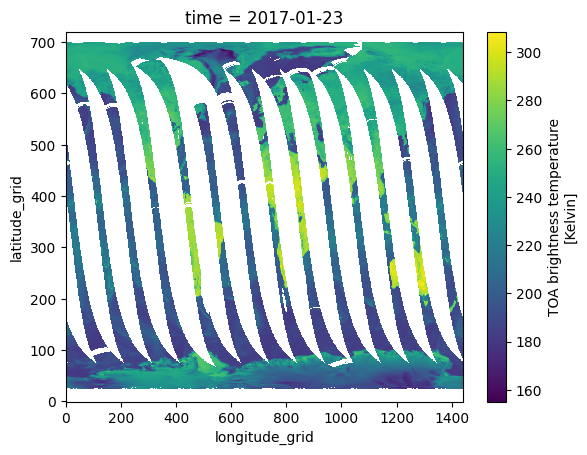

In [107]:
# monthly_data.sel(swath_sector=0, frequency_band=0, polarization=0, time = datetime(2017,1,23)).tbtoa.plot()

In [108]:
# save_folder = r"../data/processed"
# name = f"Windsat_{year}_{str(month).zfill(2)}_TBToA.nc"
# savepath = os.path.join(save_folder, name)
# monthly_data.to_netcdf()